In [1]:
import uuid

from IPython.core.display_functions import display

from tapestry.evaluate import evaluate_tensor_value
from tapestry.graph_algorithms import (
    strip_blocks,
    shard_max_dim,
    specialize_read_slices,
    strip_orphan_values,
    section_plan_max_dim,
    expand_section_plans,
)
from tapestry.jupyter_utils import display_graph
import numpy as np
import torch
from typing import Optional, Dict, Tuple

from tapestry.expression_graph import (
    BlockOperation,
    TapestryGraph,
    AggregateTensor,
    TensorValue,
    WriteSlice,
)
from tapestry.zspace import EmbeddingMode, ZRange, ZRangeMap, ZTransform, assert_shape

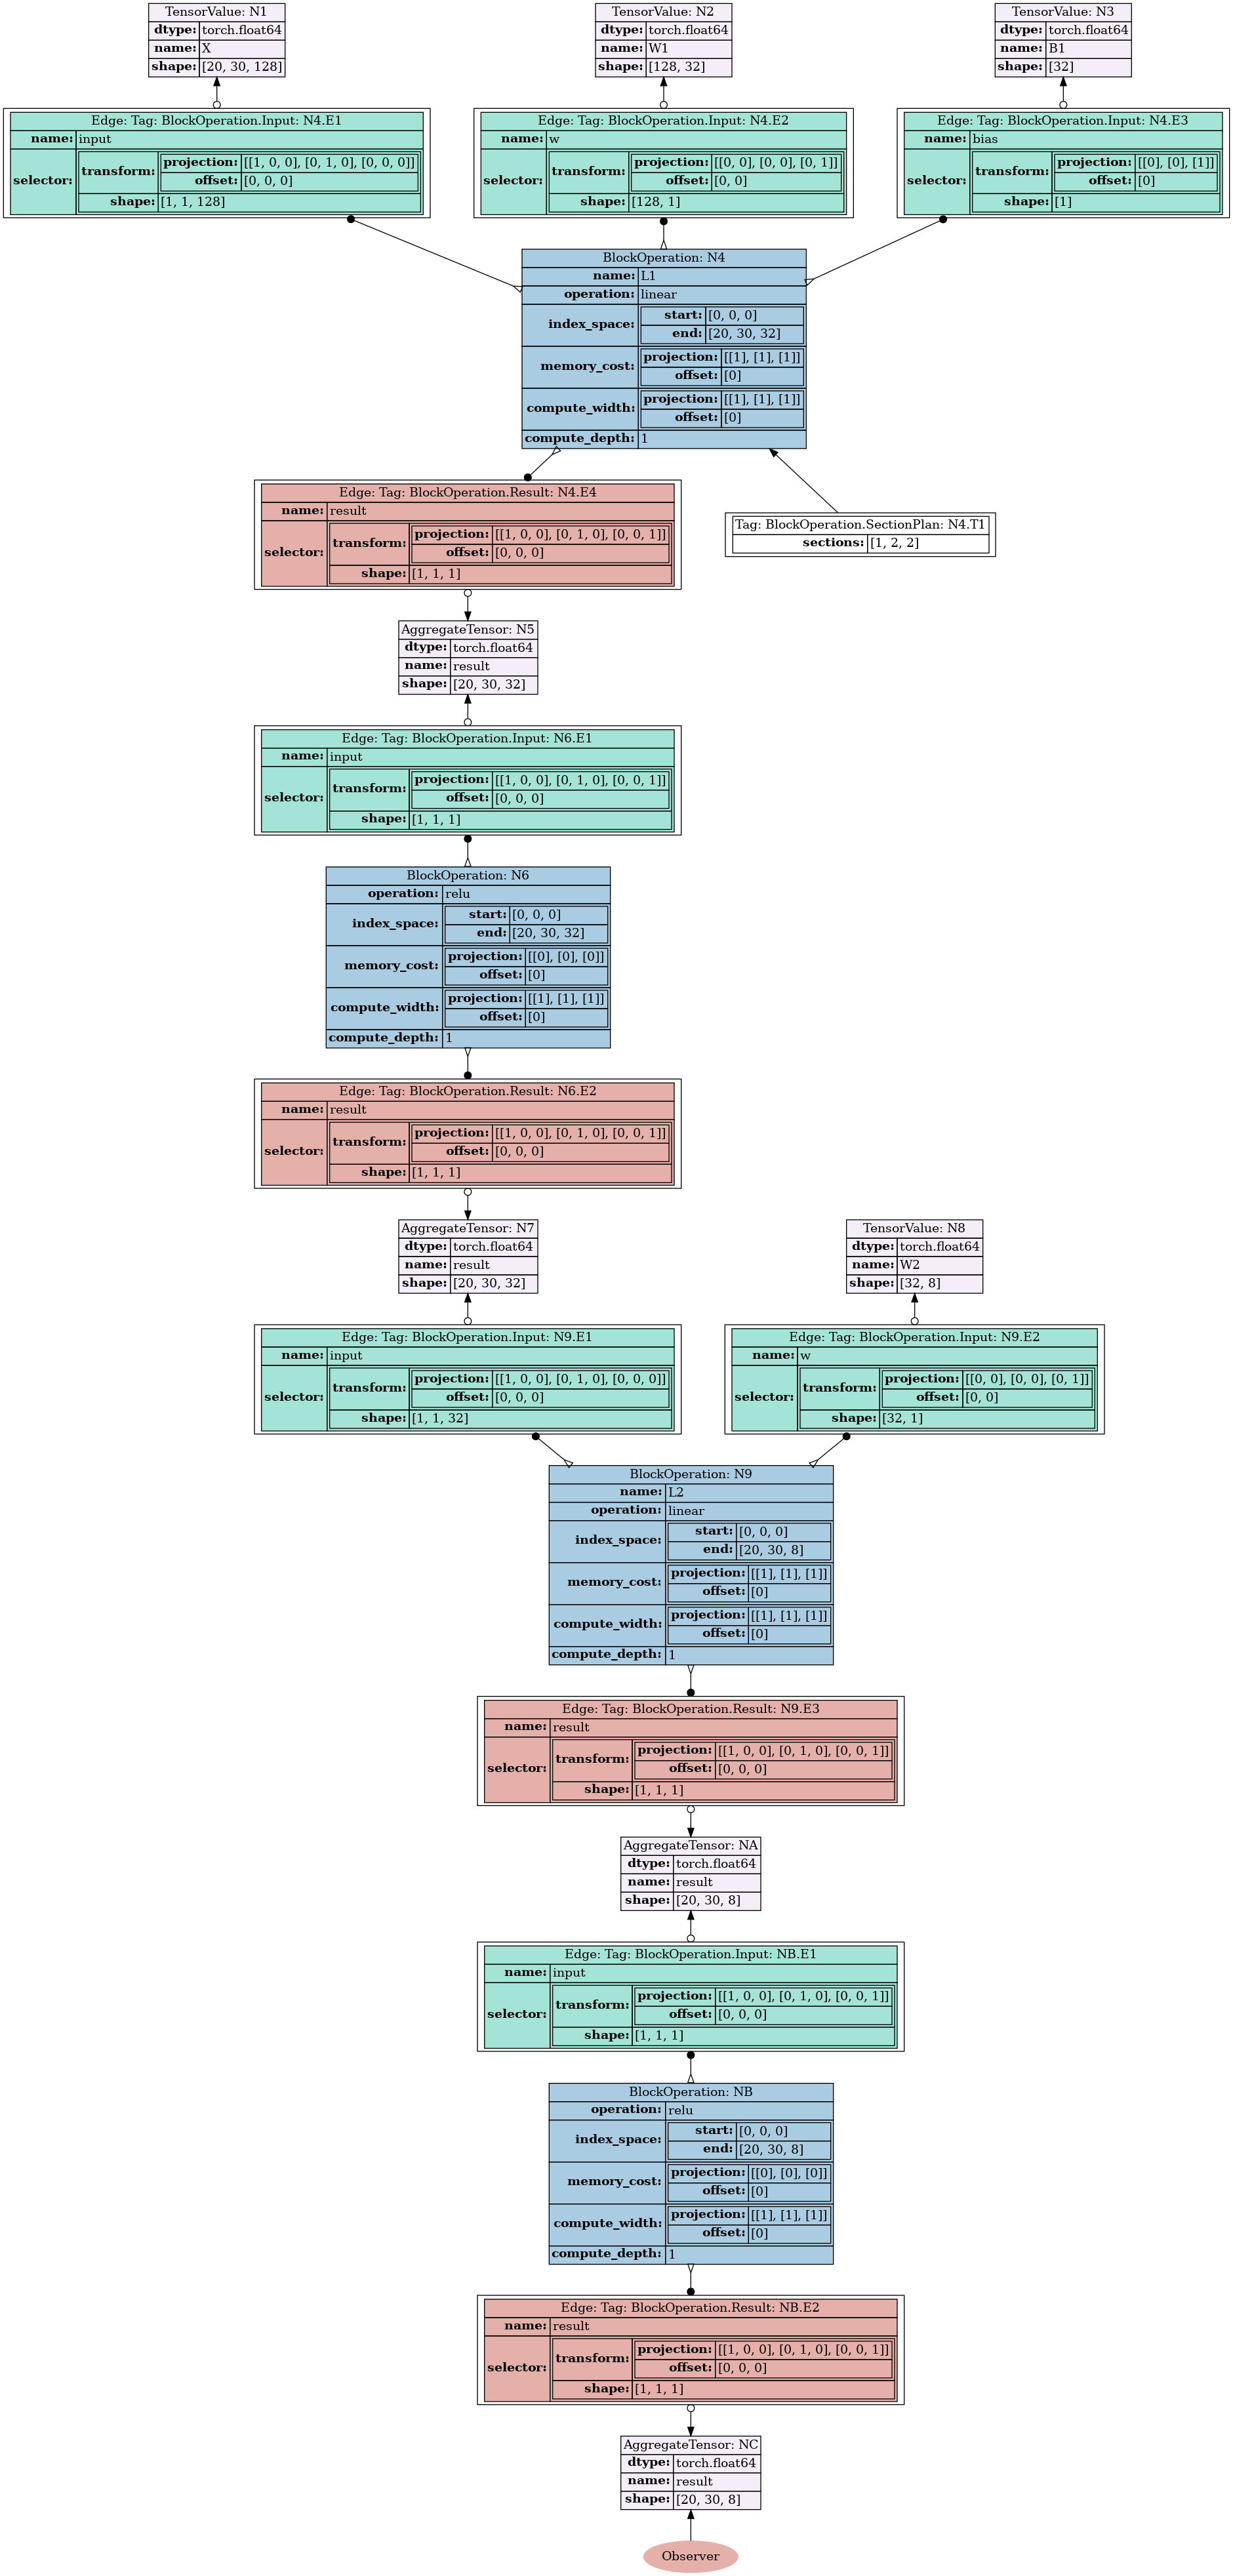

In [2]:
def linear_impl(
    params: Dict[str, torch.Tensor],
) -> Dict[str, torch.Tensor]:
    x = params["input"]
    w = params["w"]
    bias = params.get("bias")
    return {"result": torch.nn.functional.linear(x, w.T, bias)}


def linear_op(
    *,
    name: str = None,
    x: TensorValue,
    w: TensorValue,
    bias: Optional[TensorValue] = None,
) -> AggregateTensor:
    graph = x.assert_graph()
    assert w.graph == graph

    assert len(w.shape) == 2, w.shape
    in_dim = w.shape[0]
    out_dim = w.shape[1]

    assert_shape(
        x.shape[-1:],
        w.shape[:1],
        "input shape {xshape} in_dim {actual} incompatible "
        "with weight shape {wshape} in_dim {expected}",
        xshape=x.shape,
        wshape=w.shape,
    )

    index_space = ZRange(x.shape[:-1].tolist() + [out_dim])

    op = graph.add_node(
        BlockOperation(
            name=name,
            operation="linear",
            index_space=index_space,
            memory_cost=ZTransform(
                projection=np.ones((index_space.ndim, 1)),
            ),
            compute_width=ZTransform(
                projection=np.ones((index_space.ndim, 1)),
            ),
            compute_depth=1,
        )
    )

    op.bind_input(
        name="input",
        value=x,
        selector=ZRangeMap(
            transform=ZTransform(
                projection=[
                    [1, 0],
                    [0, 0],
                ],
            ),
            shape=[1, in_dim],
        ).embed(op.index_space.ndim, mode=EmbeddingMode.TILE),
    )

    projection = np.zeros((index_space.ndim, 2))
    projection[-1, -1] = 1

    op.bind_input(
        name="w",
        value=w,
        selector=ZRangeMap(
            transform=ZTransform(
                projection=projection,
            ),
            shape=[in_dim, 1],
        ).embed(op.index_space.ndim, mode=EmbeddingMode.CLIP),
    )

    if bias is not None:
        assert_shape(
            bias.shape,
            w.shape[-1:],
            "bias shape {actual} != weight [out_dim] {expected}",
        )

        op.bind_input(
            name="bias",
            value=bias,
            selector=ZRangeMap(
                transform=ZTransform(projection=[[0], [1]]),
                shape=[1],
            ).embed(op.index_space.ndim, mode=EmbeddingMode.CLIP),
        )

    result = op.bind_result(
        name="result",
        selector=ZRangeMap(
            transform=ZTransform(
                projection=[[1, 0], [0, 1]],
            ),
            shape=[1, 1],
        ).embed(op.index_space.ndim, mode=EmbeddingMode.TILE),
        dtype=x.dtype,
    )

    return result


def relu_impl(
    params: Dict[str, torch.Tensor],
) -> Dict[str, torch.Tensor]:
    x = params["input"]
    return {"result": torch.nn.functional.relu(x)}


def relu_op(
    value: TensorValue,
) -> AggregateTensor:
    graph = value.assert_graph()

    index_space = ZRange(value.shape)

    op = graph.add_node(
        BlockOperation(
            operation="relu",
            index_space=index_space,
            memory_cost=ZTransform(
                projection=np.zeros((index_space.ndim, 1)),
            ),
            compute_width=ZTransform(
                projection=np.ones((index_space.ndim, 1)),
            ),
            compute_depth=1,
        )
    )

    selector = ZRangeMap.identity_map().embed(
        op.index_space.ndim,
        mode=EmbeddingMode.TILE,
    )

    op.bind_input(
        name="input",
        value=value,
        selector=selector,
    )

    result = op.bind_result(
        name="result",
        selector=selector,
        dtype=value.dtype,
    )

    return result


def build_example_graph():
    g = TapestryGraph()

    x = g.add_node(
        TensorValue(
            name="X",
            shape=[20, 30, 128],
            dtype=torch.float64,
        )
    )

    w1 = g.add_node(
        TensorValue(
            name="W1",
            shape=[128, 32],
            dtype=torch.float64,
        )
    )

    b1 = g.add_node(
        TensorValue(
            name="B1",
            shape=[32],
            dtype=torch.float64,
        )
    )

    a = linear_op(name="L1", x=x, w=w1, bias=b1)

    y = relu_op(a)

    w2 = g.add_node(
        TensorValue(
            name="W2",
            shape=[32, 8],
            dtype=torch.float64,
        )
    )

    z = relu_op(linear_op(name="L2", x=y, w=w2))

    g.mark_observed(z)

    return g


unsharded = build_example_graph()

g = unsharded.clone()

# TODO: better node path / name lookup semantics.
# Q: are names unique? grouped? here are errors thrown?
# _we_ have unique IDs; might be easier to require exeternal maps.
l1 = g.list_nodes(BlockOperation, filter=lambda n: n.name == "L1")[0]

# demonstrate manual sectioning.
l1.attach_section_plan([1, 2, 2])

display_graph(g)

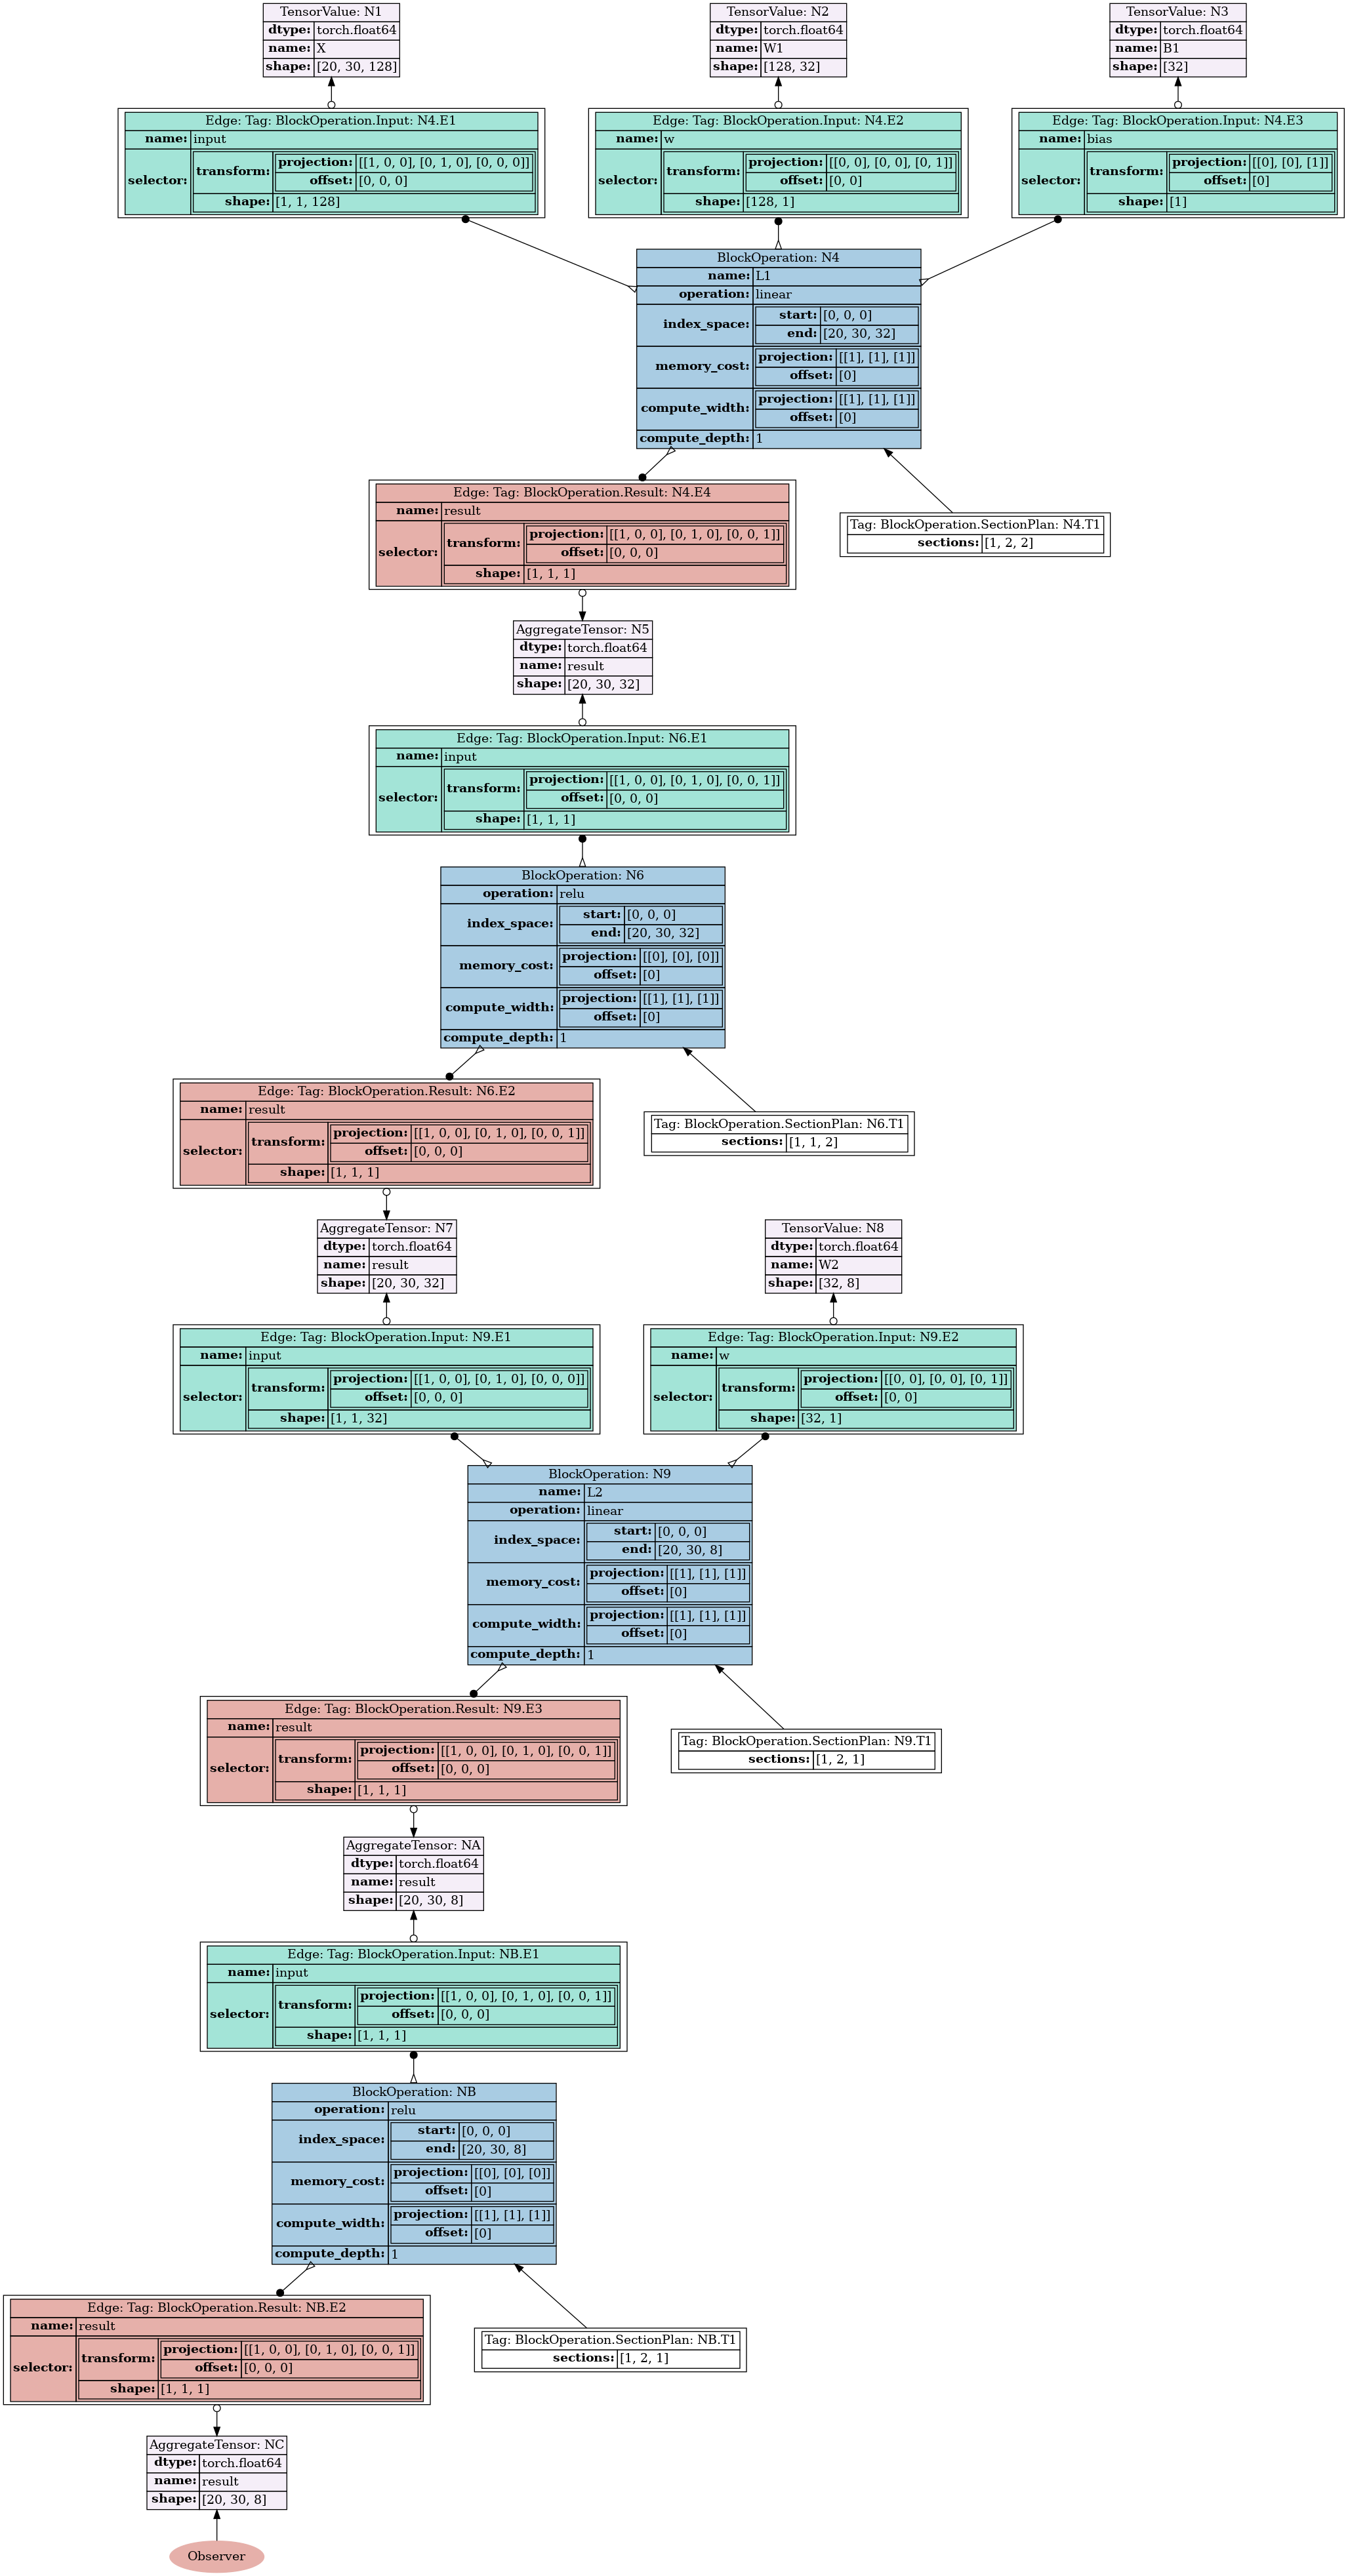

In [3]:
sectioned = g.clone()
section_plan_max_dim(sectioned, 2)
display_graph(sectioned)

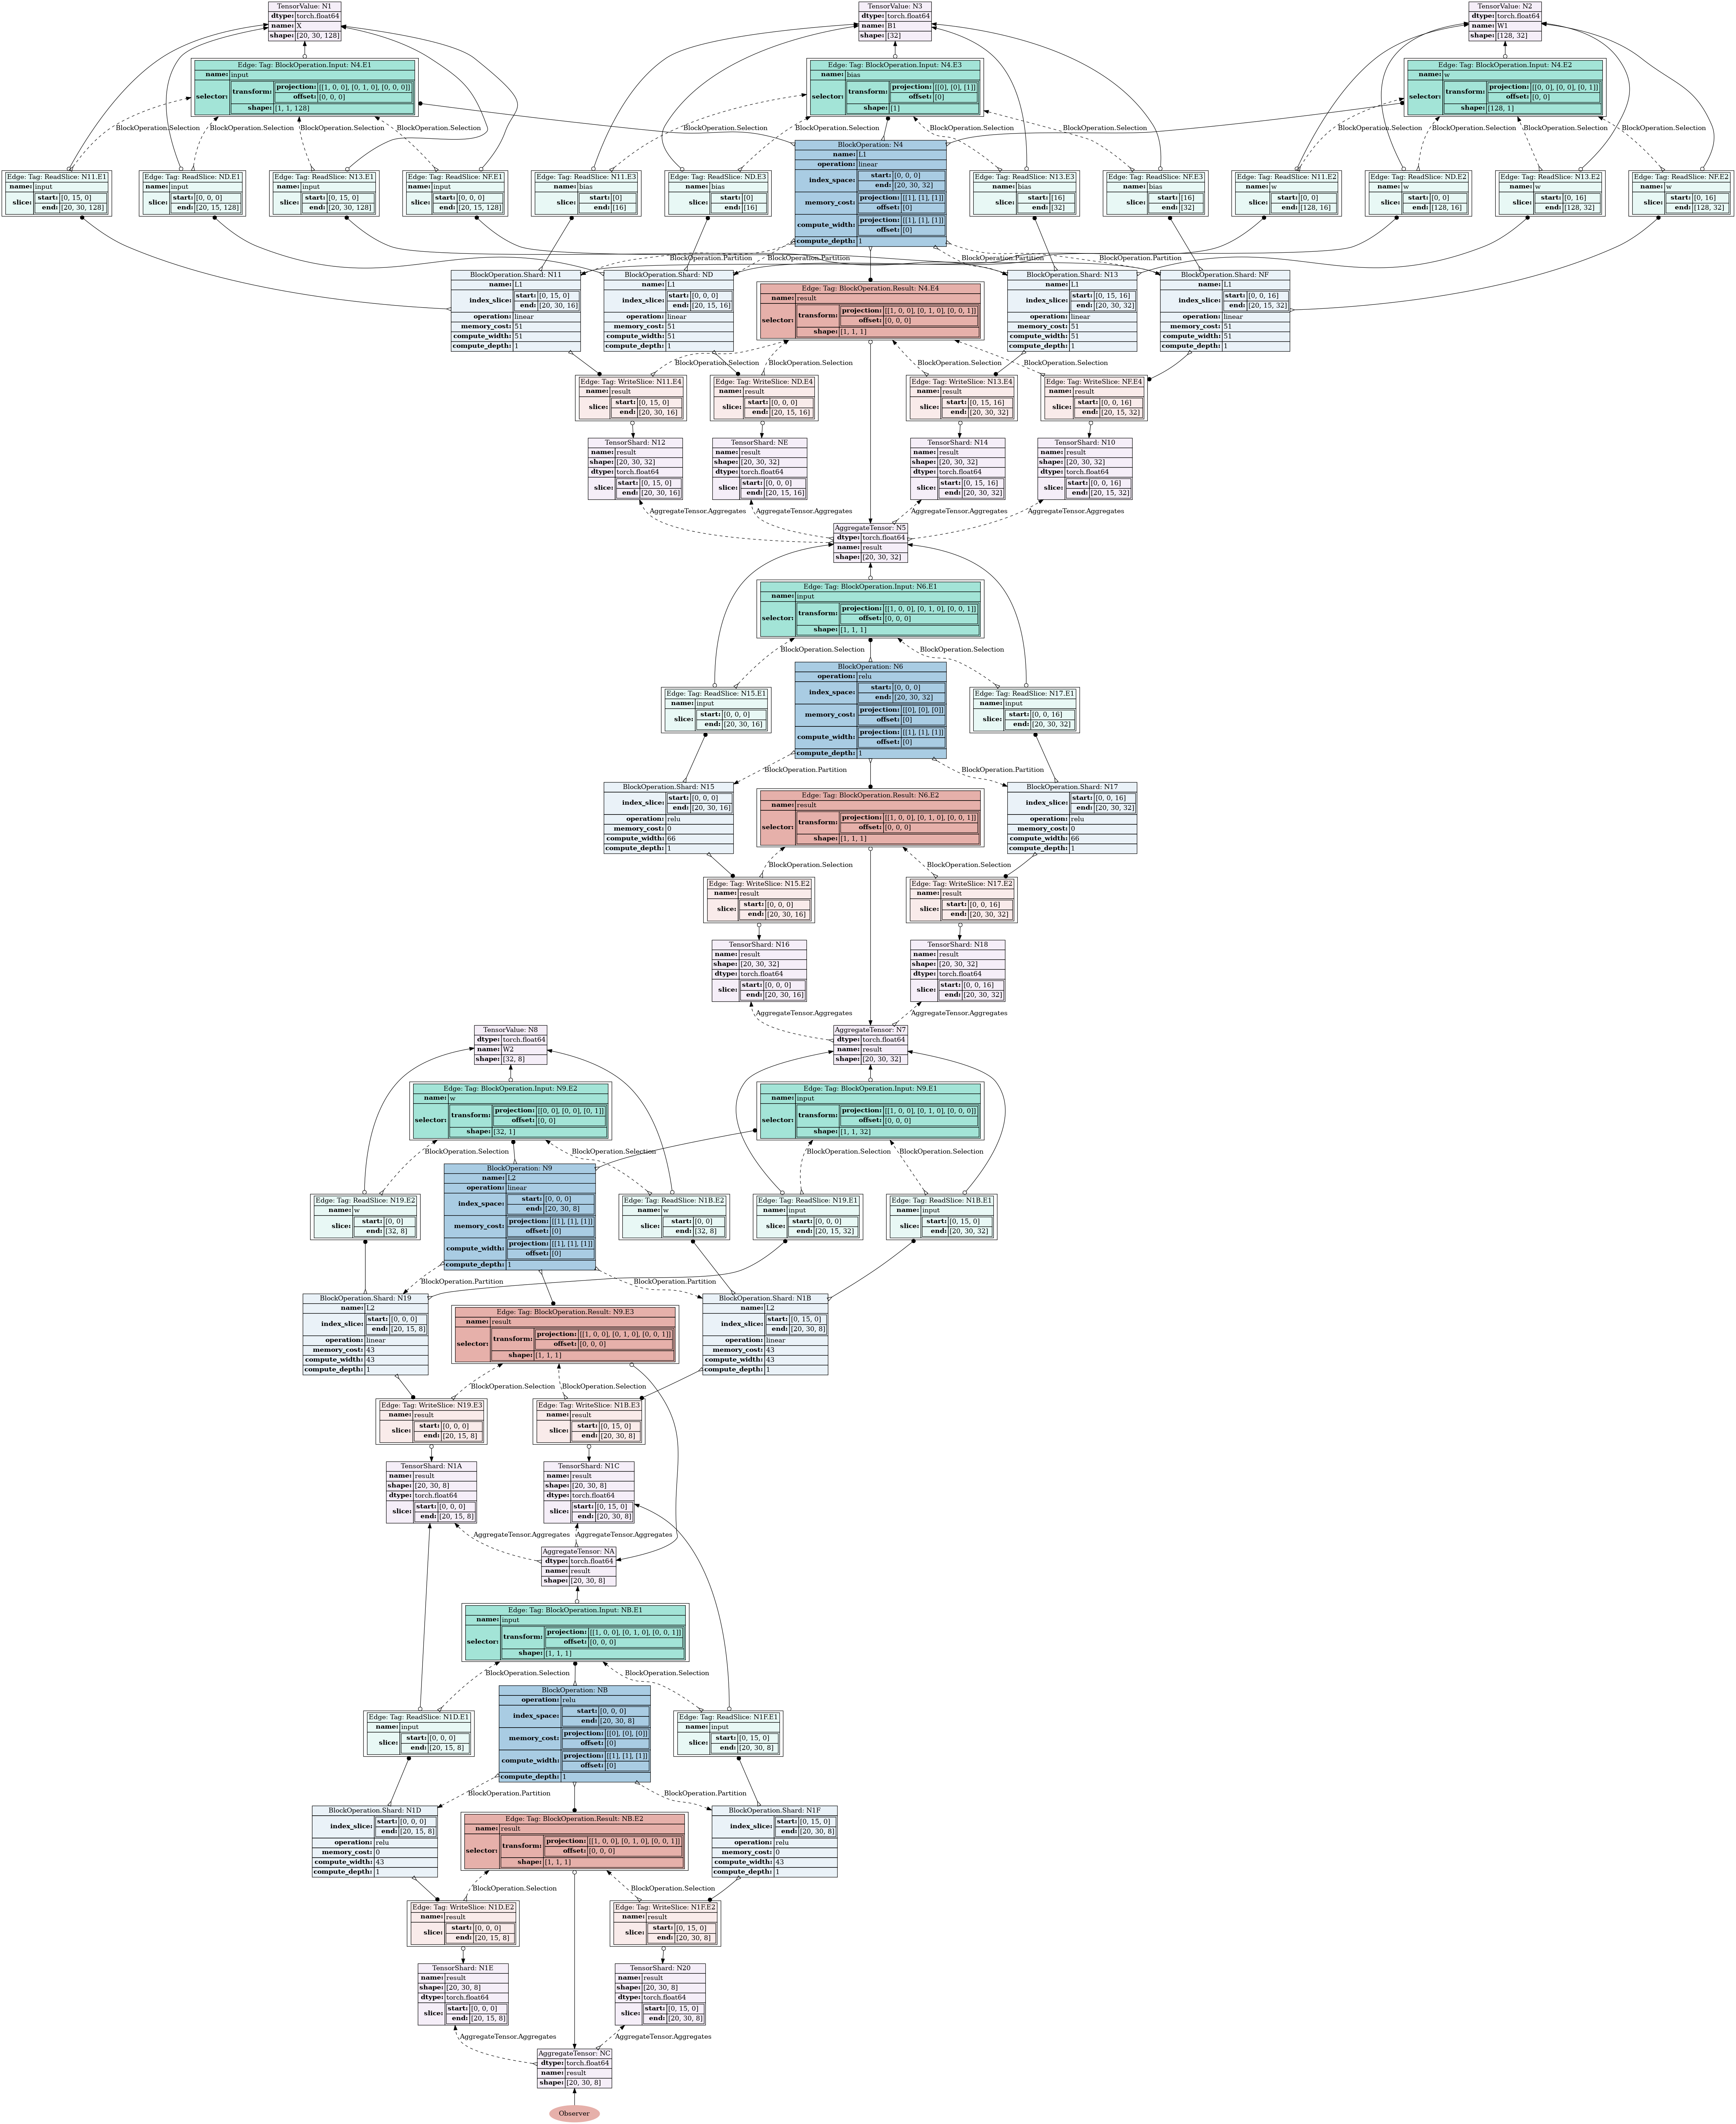

In [4]:
sharded = sectioned.clone()
expand_section_plans(sharded)
specialize_read_slices(sharded)
display_graph(sharded)

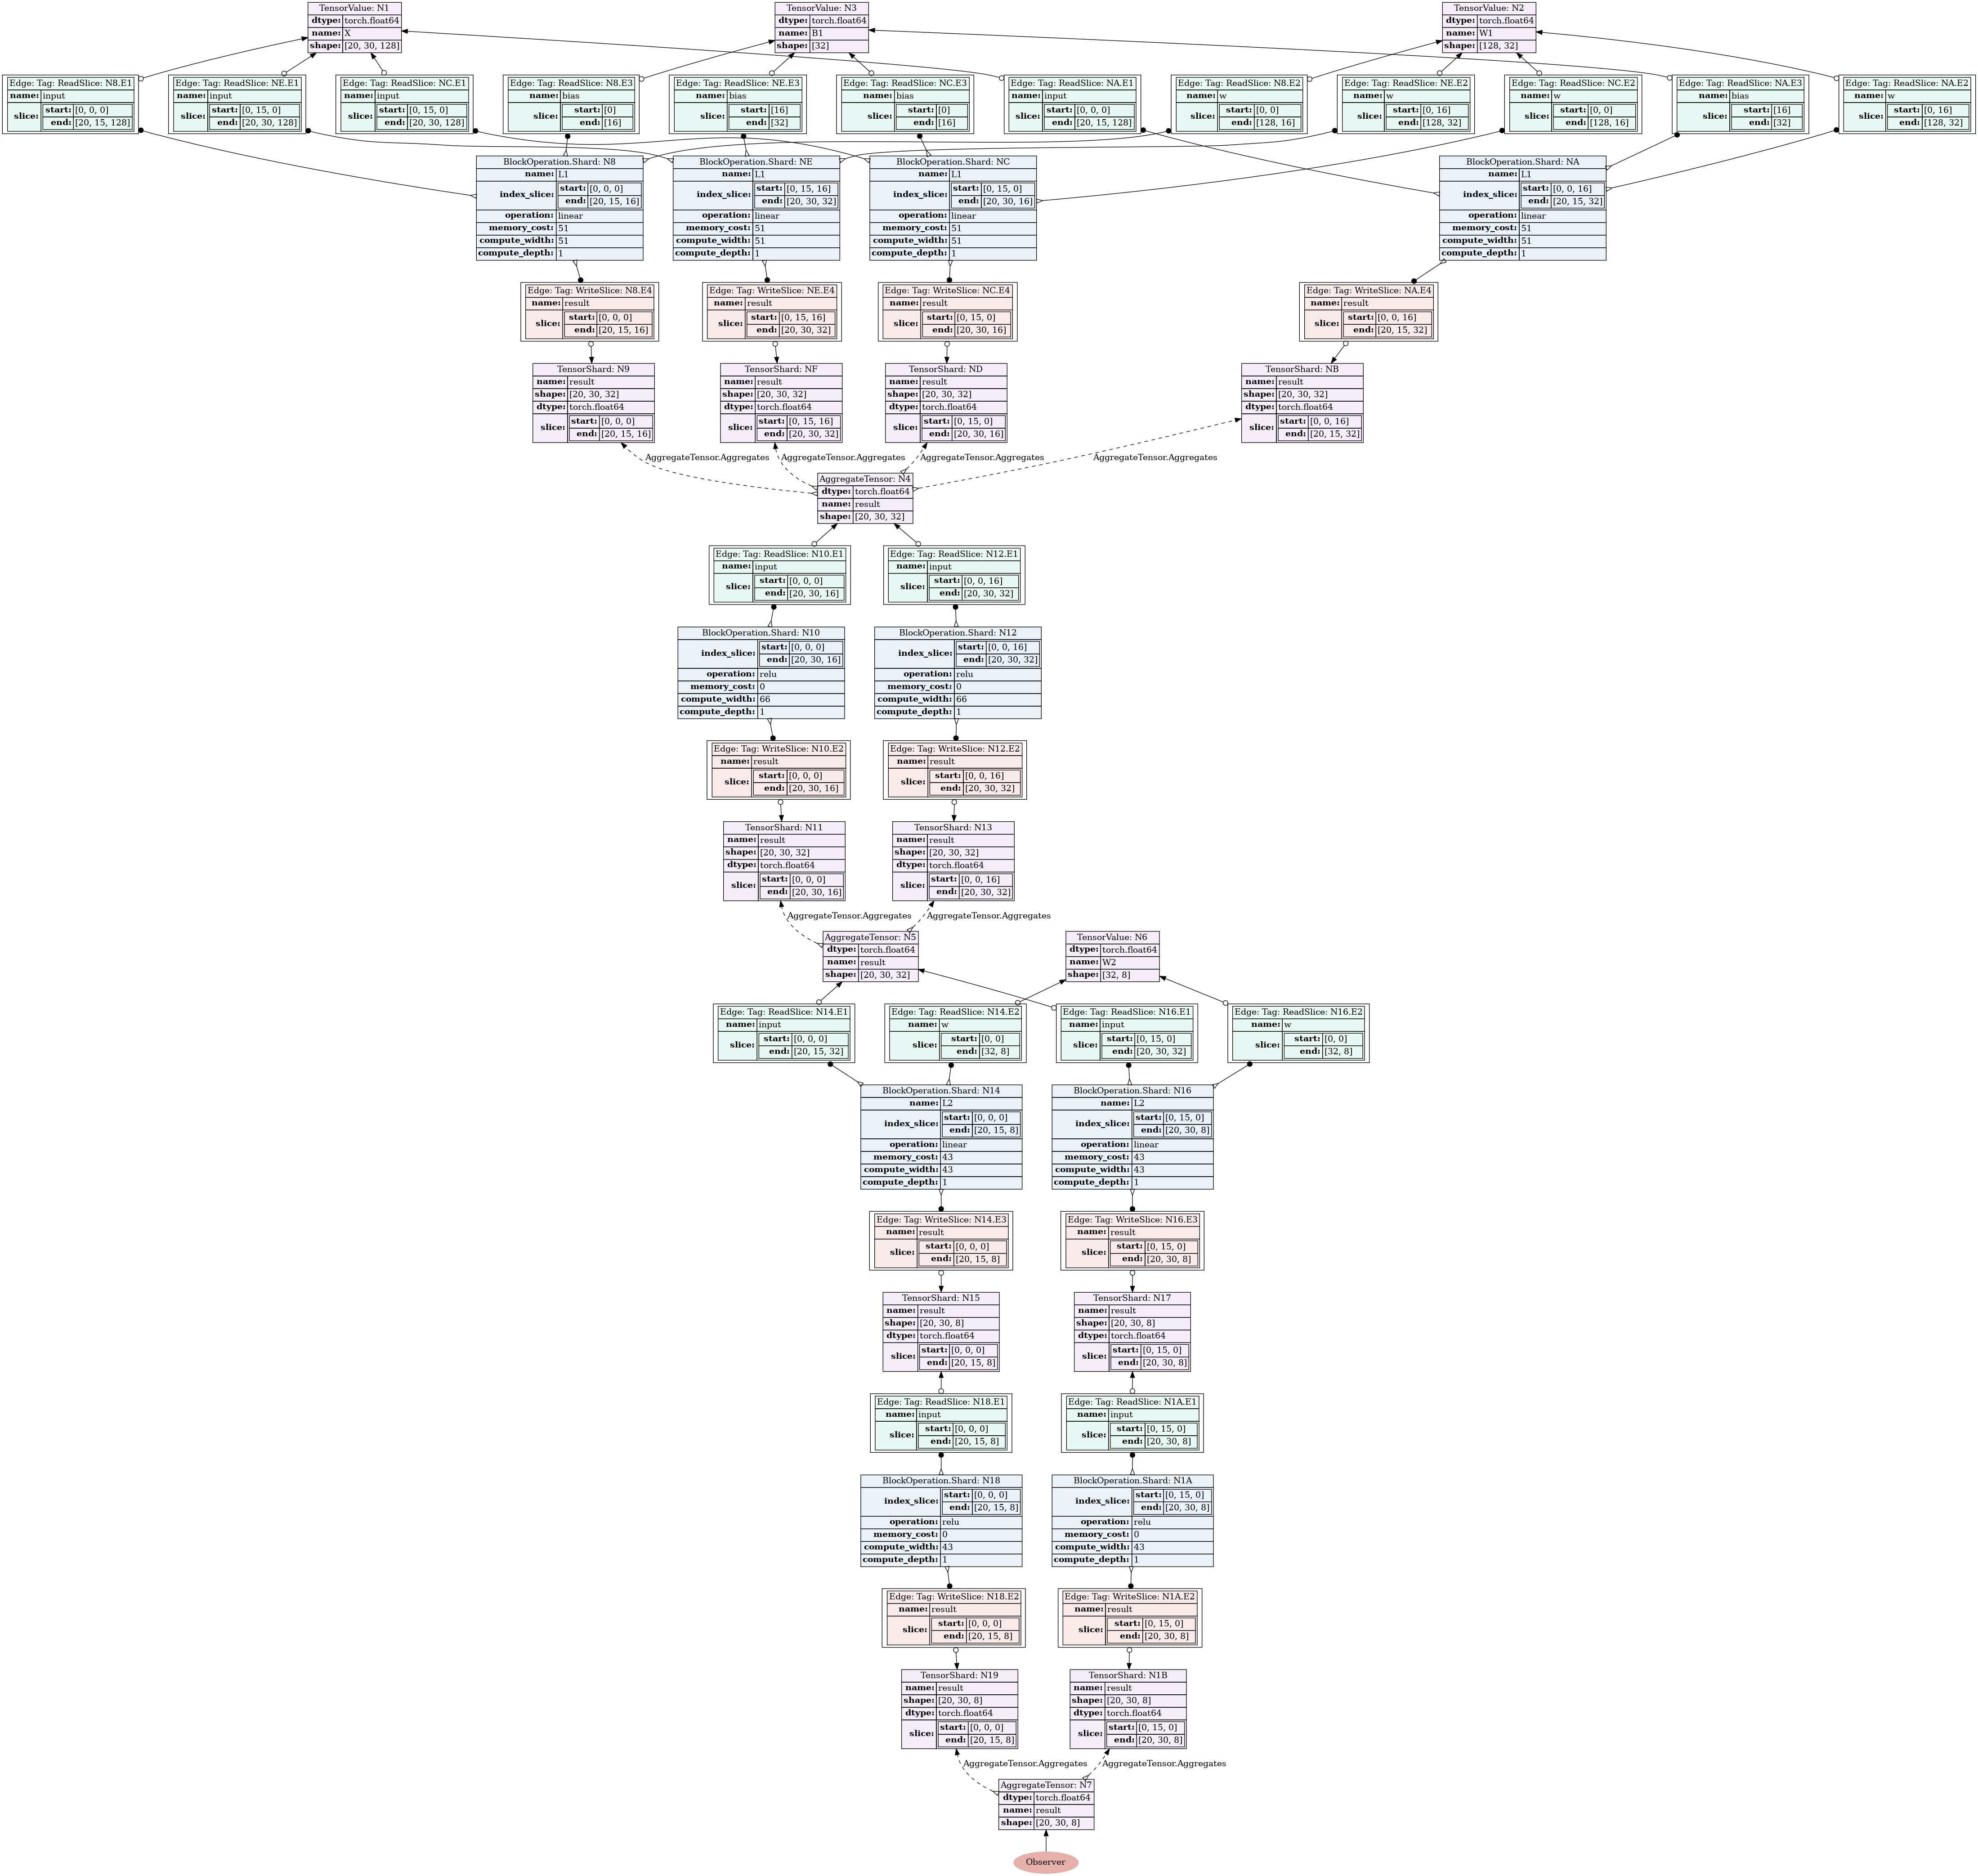

In [5]:
shard_only = sharded.clone()
strip_blocks(shard_only)
strip_orphan_values(shard_only)
display_graph(shard_only)

In [6]:
from tapestry import evaluate

tv_values = {}
for tv in shard_only.list_nodes(TensorValue):
    if not shard_only.list_edges(target_id=tv, edge_type=WriteSlice):
        # this value is external.
        tv_values[tv.node_id] = torch.rand(tuple(tv.shape), dtype=tv.dtype)

operations = {
    "linear": linear_impl,
    "relu": relu_impl,
}


def evaluate_graph(
    g: TapestryGraph,
    inputs: Dict[uuid.UUID, torch.Tensor],
    bound_operations: Dict[str, evaluate.OpType],
) -> Tuple[Dict[uuid.UUID, torch.Tensor], evaluate.Environment]:
    env = evaluate.Environment()
    env.values.update(inputs)
    env.operations.update(bound_operations)

    obs = {node_id: g.get_node(node_id) for node_id in g.observed}
    vals = {}

    for node in obs.values():
        vals[node.node_id] = evaluate_tensor_value(node, env=env)

    return vals, env


v1, _env = evaluate_graph(shard_only, tv_values, operations)

simple = unsharded.clone()
shard_max_dim(simple, 1)
v2, _env = evaluate_graph(simple, tv_values, operations)

for k, v in v2.items():
    torch.testing.assert_allclose(v1[k], v)

display(v2)

{UUID('47a22d89-86a6-43b6-aeb9-883551c01ab1'): tensor([[[0.4545, 0.4058, 0.6021,  ..., 0.8351, 0.6344, 0.1466],
          [0.3616, 0.4602, 0.5745,  ..., 0.9954, 0.6407, 0.5237],
          [0.8316, 0.1404, 0.6577,  ..., 0.1138, 0.1314, 0.8493],
          ...,
          [0.2436, 0.7936, 0.5809,  ..., 0.9246, 0.4390, 0.7682],
          [0.2030, 0.7449, 0.6721,  ..., 0.0307, 0.4433, 0.4699],
          [0.7916, 0.0932, 0.4288,  ..., 0.6795, 0.8377, 0.9561]],
 
         [[0.6110, 0.9344, 0.0203,  ..., 0.7573, 0.7993, 0.6322],
          [0.7108, 0.8448, 0.1405,  ..., 0.1614, 0.9426, 0.4662],
          [0.9624, 0.1237, 0.7352,  ..., 0.8289, 0.3386, 0.7171],
          ...,
          [0.6241, 0.6009, 0.7606,  ..., 0.4079, 0.2258, 0.6320],
          [0.2981, 0.3278, 0.2780,  ..., 0.1706, 0.5913, 0.7063],
          [0.1576, 0.5173, 0.7289,  ..., 0.3406, 0.3611, 0.9702]],
 
         [[0.5514, 0.5471, 0.3782,  ..., 0.0922, 0.1581, 0.5557],
          [0.0202, 0.4361, 0.7174,  ..., 0.8365, 0.1134, 0.7